In [52]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [53]:
from tensorflow import keras

from src.preprocessing import dataset_preprocessing
from src.custom_mobilenet_v2 import MobileNet_v2
from src.plotting import plot_training_history, plotting_confusion_matrix, plot_test_images

In [54]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 70
DROPOUT = 0.2
SCALE = 127.5
OFFSET = -1
FREEZING_PERCENTAGE = 1


PATH = "..\dataset_04"
MODEL_NAME = "03_mobilenet_v2_0.35_224"
SAVE = True

In [55]:
dataset = keras.utils.image_dataset_from_directory(PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.80,
                                                                              validation_size=0.1, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

Found 1378 files belonging to 3 classes.


In [56]:
number_classes

3

In [57]:
class_names

['erogazione corretta', 'senza paletta', 'vuoto']

In [58]:
print('Number of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Number of training images: 1088
Number of validation images: 128
Number of testing images: 192


In [59]:
pre_trained_model = keras.applications.MobileNetV2(input_shape = INPUT_SHAPE, 
                                                   include_top=False, 
                                                   weights='imagenet',
                                                   alpha=0.35,
                                                   classes=number_classes)

In [60]:
model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT)

count = 0
for i, layer in enumerate(pre_trained_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        count = count +1 

for i in range(int(count*FREEZING_PERCENTAGE)):
    model.layers[i].trainable= False

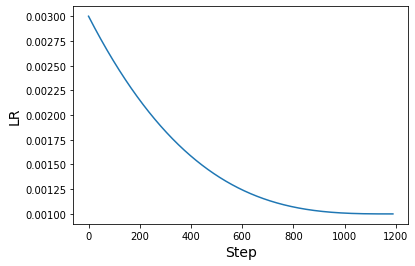

In [62]:
dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

learning_rate_fn = keras.optimizers.schedules.PolynomialDecay(
    5e-3,
    total_steps,
    1e-3,
    power=3)

import matplotlib.pyplot as plt
import numpy as np

lrs = learning_rate_fn(np.arange(0,total_steps))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [63]:

model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate_fn),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/70
17/17 [==============================] - 70s 2s/step - loss: 0.6992 - accuracy: 0.7013 - val_loss: 0.3814 - val_accuracy: 0.8984
Epoch 2/70
17/17 [==============================] - 9s 537ms/step - loss: 0.4057 - accuracy: 0.8336 - val_loss: 0.3551 - val_accuracy: 0.8828
Epoch 3/70
17/17 [==============================] - 9s 536ms/step - loss: 0.3114 - accuracy: 0.8741 - val_loss: 0.2738 - val_accuracy: 0.9141
Epoch 4/70
17/17 [==============================] - 9s 544ms/step - loss: 0.2861 - accuracy: 0.8722 - val_loss: 0.2424 - val_accuracy: 0.9219
Epoch 5/70
17/17 [==============================] - 9s 548ms/step - loss: 0.2741 - accuracy: 0.8869 - val_loss: 0.2390 - val_accuracy: 0.9297
Epoch 6/70
17/17 [==============================] - 10s 606ms/step - loss: 0.2368 - accuracy: 0.9053 - val_loss: 0.1969 - val_accuracy: 0.9453
Epoch 7/70
17/17 [==============================] - 10s 569ms/step - loss: 0.1948 - accuracy: 0.9329 - val_loss: 0.1930 - val_accuracy: 0.9375
Epoch 

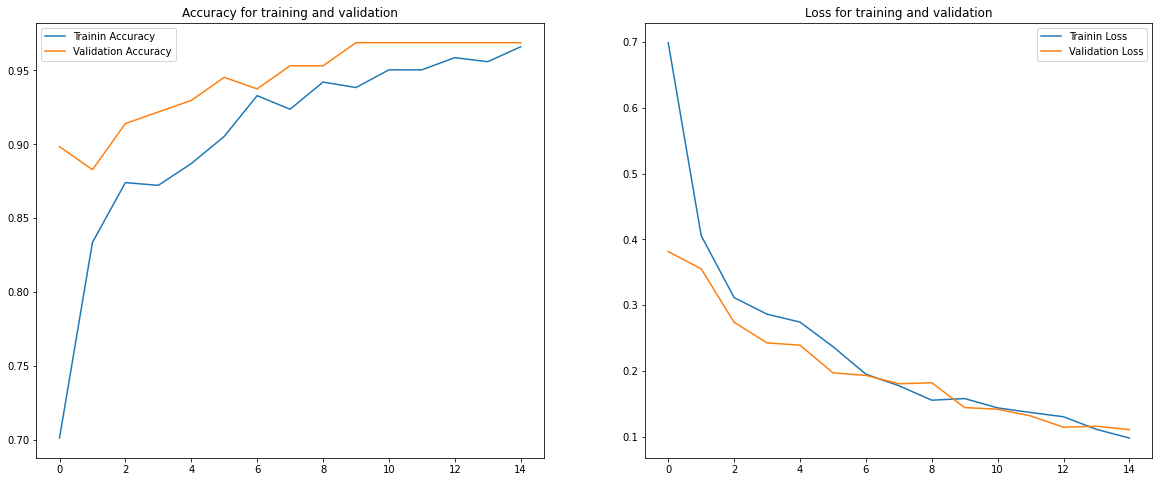

In [64]:
plot_training_history(history)

In [65]:
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Accuracy: ', round(baseline_accuracy*100, 3), '%')

Accuracy:  95.833 %


In [66]:
if SAVE:
    model.save('saved_models/' + MODEL_NAME + '.keras')
    print("Salvato")

Salvato


6/6 [==============================] - 3s 337ms/step


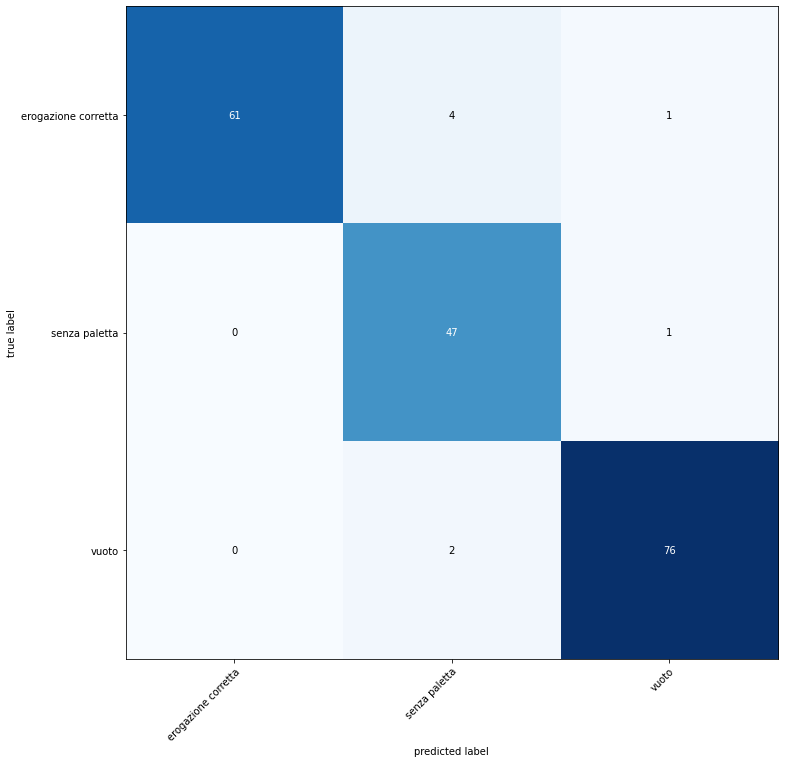

In [70]:
plotting_confusion_matrix(testing_dataset, model, class_names)

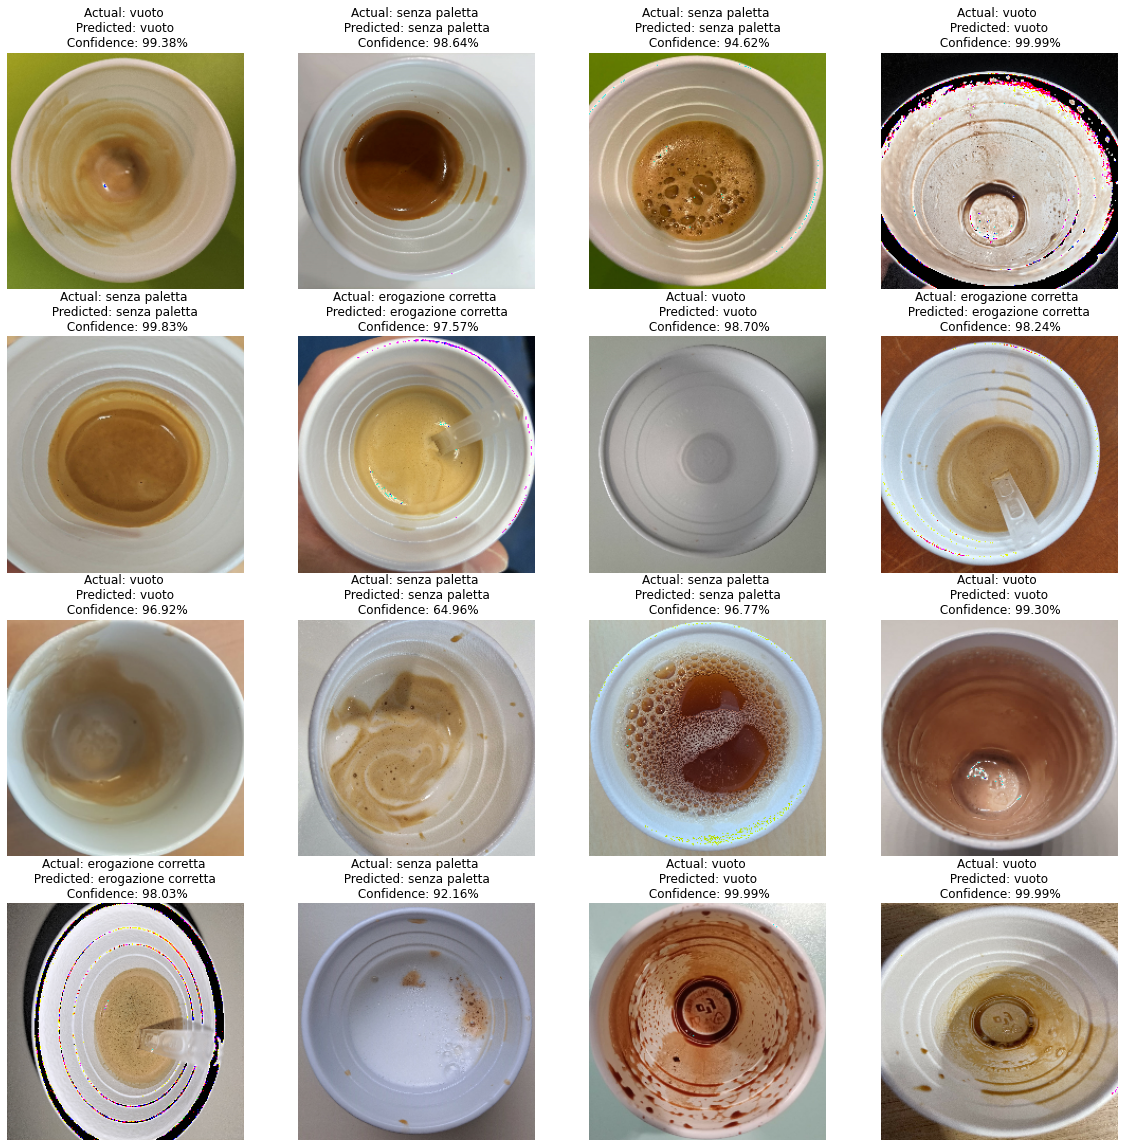

In [68]:
plot_test_images(model, testing_dataset, class_names, num_images = 16, scaling = SCALE, offset=OFFSET)